# Automated Light GBM model Optimization and Logging
- Split into training and testing sets
- Optimize model parameters
- Automate training across n=6 countries and k=2 datasets
- Log results on MLflow server

Setup

In [12]:
import mlflow
import pandas as pd
import pickle
from pathlib import Path
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit 
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sbn
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from mlflow.models.signature import infer_signature

# Multiple outputs per notebook cell
%config InteractiveShell.ast_node_interactivity = 'all'

# random_state for different processes
RANDOM_STATE = 221

In [13]:
def num_rows_horizon(df, timeframe='7day'):
    ''' 
    Input: Dataframe, Timeframe (in to_timedelta format)
    Output: Outputs number of rows in dataframe to reach timeframe
    '''
    return len(df.loc[df['day'] > (df['day'].max() - pd.to_timedelta('7day'))])

# validate test
def trainval_test_split(df):
    '''
    Input: Dataframe from features prep
    Output: Train and final test sets with a 7 day window
    '''
    train_validate = df.loc[df['day'] < (df['day'].max() - pd.to_timedelta('7day'))]
    final_test = df.loc[df['day'] > (df['day'].max() - pd.to_timedelta('8day'))]

    return train_validate, final_test

# train validate
def load_train_test(df, drop_index=True):
    ''' 
    Input: Dataframe from features prep
    Output: Data prepared for hyperparameter search
    '''
    X = (df.drop(columns=['load_actual', 'country', 'day']) 
           .dropna()
           .reset_index()
           )
    if drop_index:
        X = X.drop(columns='utc_timestamp')
     
    y = (df.reset_index(drop=True)[['load_actual']])
    
    return X, y


### Load Data
- Creating train/test and validation sets, then ensure windows are correct

In [14]:
cd = Path.cwd()
data_dir = str(cd.parents[1])
upsampled = data_dir + '/datasets/country_energy/load_wthr_downsample.pickle'
downsampled = data_dir + '/datasets/country_energy/load_wthr_upsample.pickle'

# Xu - upsampled
with open(upsampled, 'rb') as f:
    Xu = pickle.load(f)

# Xd - downsampled
with open(downsampled, 'rb') as f:
    Xd = pickle.load(f)

# Create test/train and validation set. Ensure dates are correct
final_test_u = Xu.loc[Xu['day'] > (Xu['day'].max() - pd.to_timedelta('8day'))] # 8 days is selected because last day 2019-4-30 has 0 hours
Xu_check = Xu.loc[Xu['day'] < (Xu['day'].max() - pd.to_timedelta('7day'))]
print(f'Ensure validation set is last 7 days; min date: {final_test_u.index.min()}, max date: {final_test_u.index.max()}')
print(f'Ensure train/test set excludes last 7 days; min date: {Xu_check.index.min()}, max date: {Xu_check.index.max()}')

final_test_d = Xd.loc[Xd['day'] > (Xd['day'].max() - pd.to_timedelta('8day'))]
Xd_check = Xd.loc[Xd['day'] < (Xd['day'].max() - pd.to_timedelta('7day'))]
print(f'Ensure validation set is last 7 days; min date: {final_test_d.index.min()}, max date: {final_test_d.index.max()}')
print(f'Ensure train/test set excludes last 7 days; min date: {Xd_check.index.min()}, max date: {Xd_check.index.max()}')

Ensure validation set is last 7 days; min date: 2019-04-23 00:00:00+00:00, max date: 2019-04-30 00:00:00+00:00
Ensure train/test set excludes last 7 days; min date: 2015-01-15 00:00:00+00:00, max date: 2019-04-22 23:45:00+00:00
Ensure validation set is last 7 days; min date: 2019-04-23 00:00:00+00:00, max date: 2019-04-30 00:00:00+00:00
Ensure train/test set excludes last 7 days; min date: 2015-01-15 00:00:00+00:00, max date: 2019-04-22 23:00:00+00:00


Hyperparameter optimization and logging for MLflow

In [16]:
# Function for logging parameters from Hyperparameter Optimization function
def optimization_logs(opt_model, importance_plot, test_plot, bayes_opt, final_mape, end, country):

    # Log params, metrics, model, and plots
    mlflow.log_params(opt_model.best_params_)
    mlflow.log_table(opt_model.best_params_, f'{country}_best_params.json')
    mlflow.log_figure(importance_plot.figure, f'{country}_variable_importance.png')
    mlflow.log_figure(test_plot, f'{country}_predicted_vs_actuals.png') 
    mlflow.log_metrics({
                    'optimization_training_time': end,
                    'best_training_mape': abs(bayes_opt.best_score_),
                    'final_test_mape': final_mape,
                })
    mlflow.sklearn.log_model(sk_model=opt_model.best_estimator_, 
                              artifact_path=f"{country}_best_model"
                              )
    
def hyperparam_opt(dataset, country, iterations=25, nested_windows=10):
    with mlflow.start_run(run_name=f'{country}_model_optimization', nested=True): 
        # Split into training/validation/test
        train, test = trainval_test_split(dataset)
        nrow = num_rows_horizon(dataset, timeframe='7day')
        X_train, y_train = load_train_test(train)

        # Nested timeseries split for cross validation
        ts_cv = TimeSeriesSplit(n_splits=nested_windows, test_size=nrow)

        # Model and callbacks
        early_stopping = lgbm.early_stopping(5)
        model = lgbm.LGBMRegressor(
                        random_state=RANDOM_STATE, 
                        n_jobs=-1,
                        callbacks=[early_stopping],
                        verbosity=-1)
        
        # Parameter set / ranges
        params = {
            'learning_rate': Real(0.001, 2, 'uniform'),
            'reg_alpha': Real(0, 1, 'uniform'),
            'num_leaves': Integer(20, 500, 'uniform'), 
            'max_depth': Integer(3, 9, 'uniform'), 
            'subsample': Real(0.5, 1, 'uniform'), 
            'colsample_bytree': Real(0.7, 1, 'uniform'),
            'reg_alpha': Real(0, 1, 'uniform'),
            'min_data_in_leaf': Integer(20, 100, 'uniform')
        } 

        # BayesSearch of optimal params
        bayes_opt = BayesSearchCV(
            model,
            params,
            cv=ts_cv,
            n_iter=iterations, # 50, 100
            scoring='neg_mean_absolute_percentage_error', # 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'
            n_jobs=-1,
            random_state=RANDOM_STATE,
            return_train_score=True,
        )

        # Run and time bayesian optimization of params
        start = time.time()
        opt_model = bayes_opt.fit(X_train, y_train)
        end = round(time.time() - start, 2)

        # Variable Importance Plot
        importance_plot = lgbm.plot_importance(bayes_opt.best_estimator_, 
                                                figsize=(8,5), 
                                                title=f'{country} Variable Importance')
        
        # Get predictions of optimal set of params for final test set
        X_test, y_test = load_train_test(test, drop_index=False)
        y_pred = opt_model.best_estimator_.predict(X_test.drop(columns='utc_timestamp'))
        y_test = np.reshape(y_test, (len(y_test),))
        final_mape = mean_absolute_percentage_error(y_test, y_pred)  

        # Time Series plot of Predicted Vs Actuals
        plot_dt = pd.DataFrame({'Day': X_test['utc_timestamp'],
                                'actual': np.reshape(y_test, (len(y_test),)), 
                                'predicted': y_pred})

        preds_vs_actual = plt.figure(figsize=(10,5))
        _ = sbn.lineplot(data=plot_dt, 
                        x='Day', 
                        y='actual', 
                        color='red', 
                        label='Actuals')
        _ = sbn.lineplot(data=plot_dt, 
                        x='Day', 
                        y='predicted', 
                        color='grey', 
                        label='Predicted')
        _ = plt.ylabel('Load (MW)')
        _ = plt.title(f'Predicted Vs. Actual Load for {country}')

        # # Log params, result metrics, and visualizations
        optimization_logs(opt_model, 
                          importance_plot, 
                          preds_vs_actual, 
                          bayes_opt, 
                          final_mape, 
                          end, 
                          country)
# extinguish any active runs
mlflow.end_run()

Automated forecasting per country

In [17]:

def automated_forecast(datasets, dataset_names, iter_per_model=25, nested_windows=10, experiment_name='No experiment name given'):

    if __name__ == "__main__":
        # Initialize server
        mlflow.set_tracking_uri("http://127.0.0.1:5000")
        mlflow.set_experiment(experiment_name)

        for name, data in zip(dataset_names, datasets):
            mlflow.start_run(run_name=f'{name} Country Energy Forcast')

            # Group data, begin process for each group in data
            country_data = data.groupby('country')

            for country, data in country_data: 
                #with mlflow.start_run(nested=True, run_name=f"Country: {country}"):
                hyperparam_opt(data, country, iterations=iter_per_model, nested_windows=nested_windows)  
               
mlflow.end_run()

Run automated forecast with selected parameters

2025/03/06 11:48:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run AT_model_optimization at: http://127.0.0.1:5000/#/experiments/122174094549120453/runs/d12887f47f06415e8069b54a5c68d83f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/122174094549120453


2025/03/06 11:51:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run BE_model_optimization at: http://127.0.0.1:5000/#/experiments/122174094549120453/runs/b87ef04e7fb34e90acce6b9f787b8446
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/122174094549120453


2025/03/06 11:54:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DE_model_optimization at: http://127.0.0.1:5000/#/experiments/122174094549120453/runs/5b6d4b7cfdb8484ca9867d26db788721
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/122174094549120453


2025/03/06 11:56:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HU_model_optimization at: http://127.0.0.1:5000/#/experiments/122174094549120453/runs/b88058f3c7a84c058da91e27fc557847
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/122174094549120453


2025/03/06 11:59:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LU_model_optimization at: http://127.0.0.1:5000/#/experiments/122174094549120453/runs/57e57052baa44a0e9b688f0cff815e13
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/122174094549120453


2025/03/06 12:02:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run NL_model_optimization at: http://127.0.0.1:5000/#/experiments/122174094549120453/runs/012e146000bd410cbdac2cfddb23fa1e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/122174094549120453


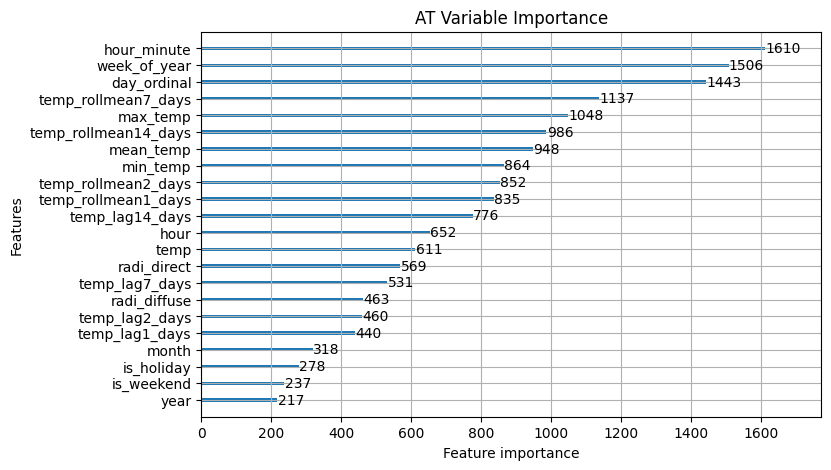

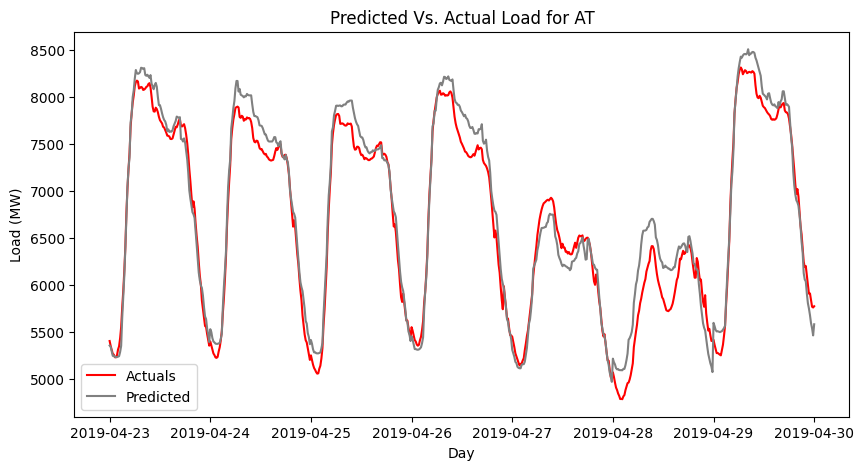

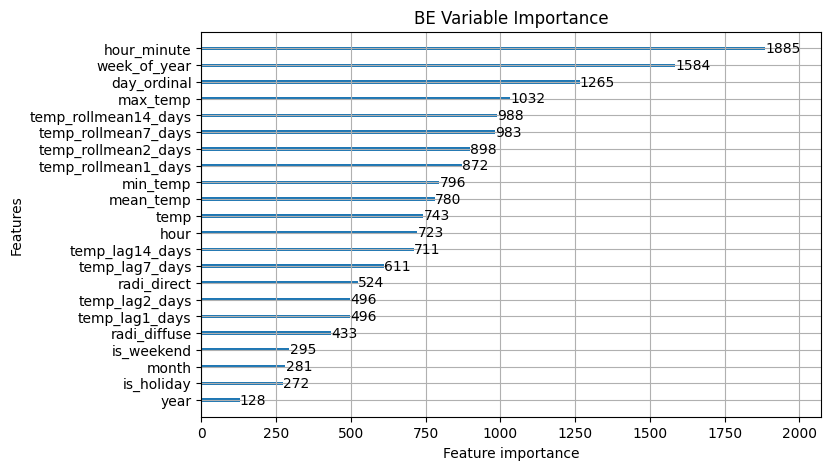

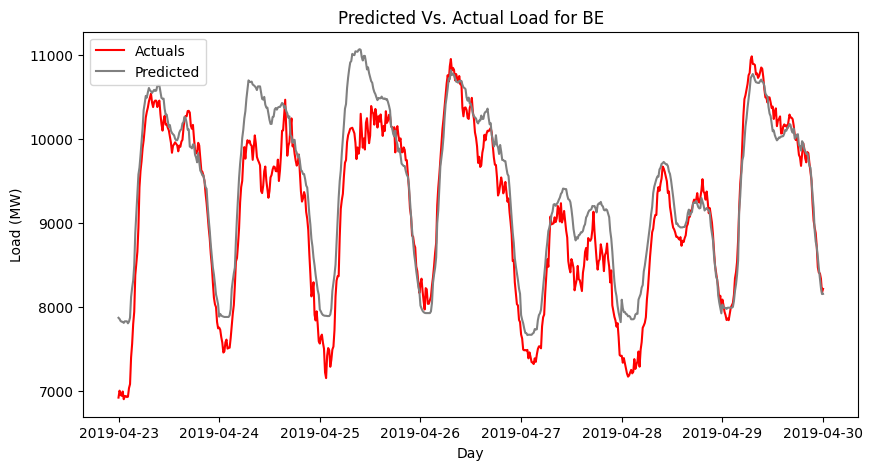

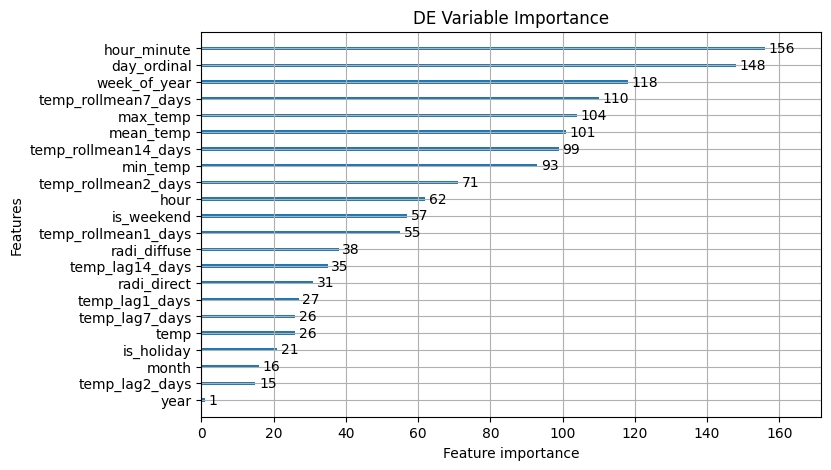

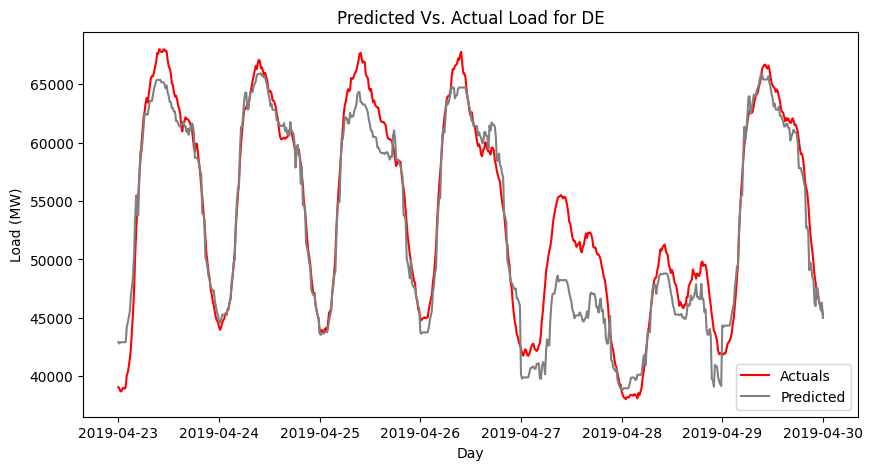

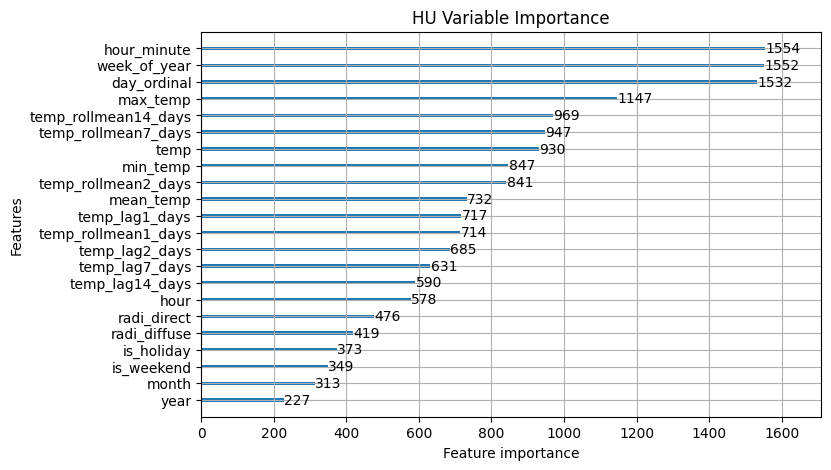

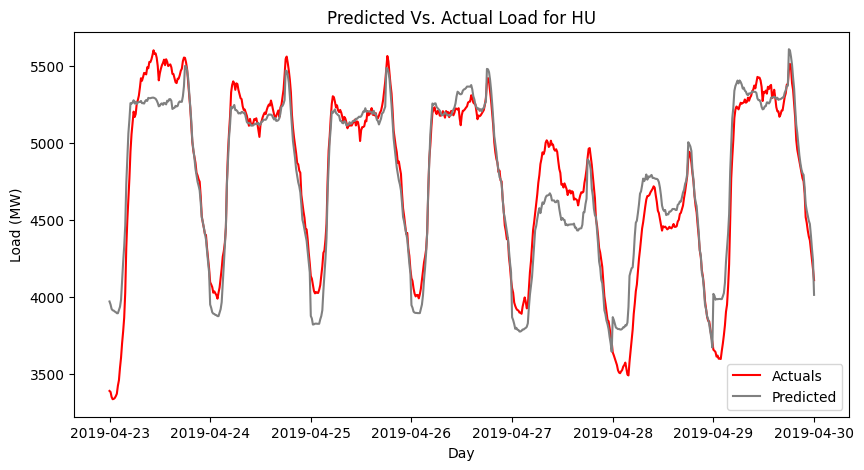

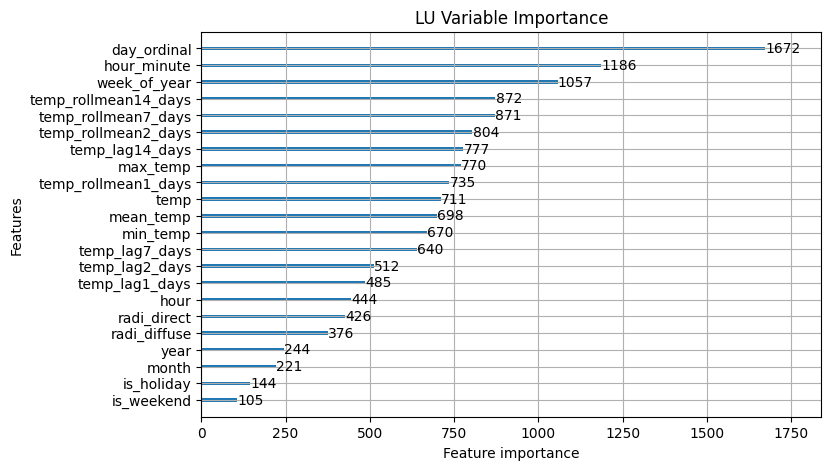

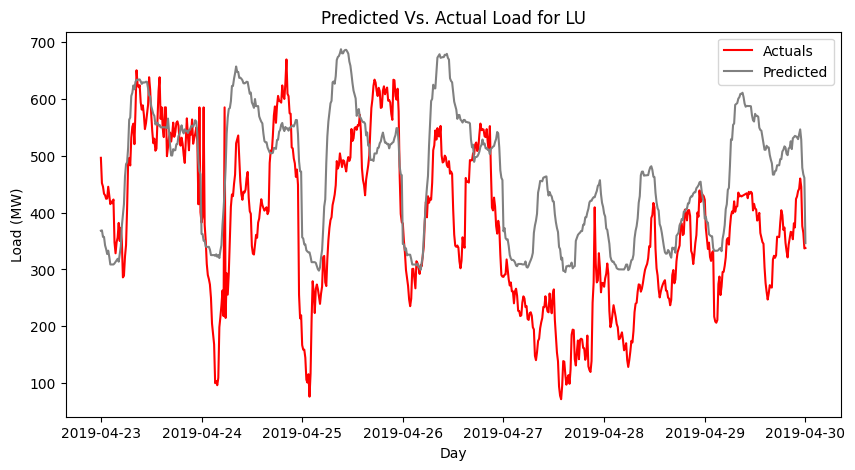

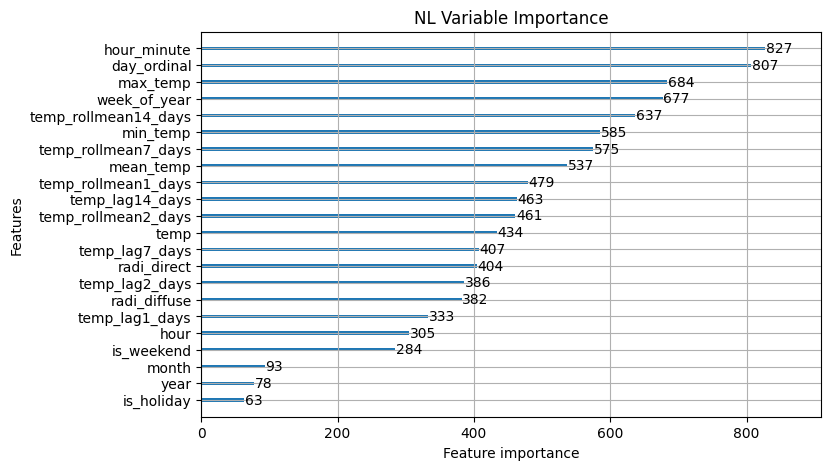

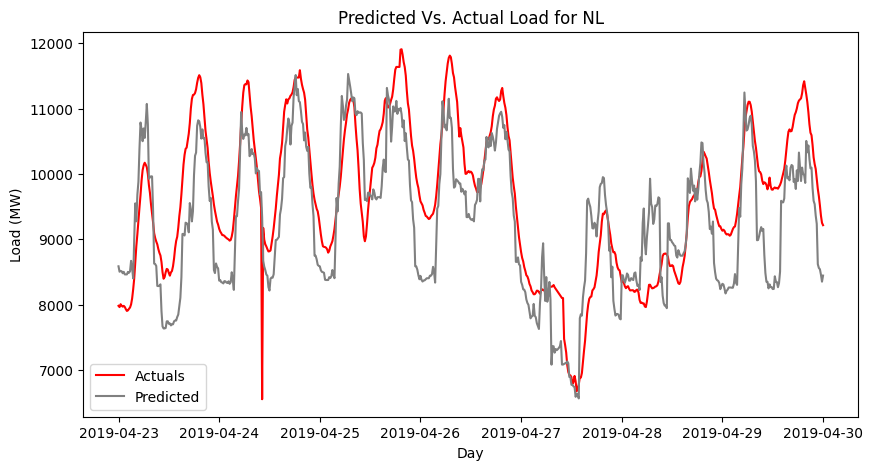

In [19]:
# # Params for testing
# datasets = [Xd, Xu] 
# dataset_names = ['1hour', '15min']
# iterations = [15, 30]

mlflow.end_run()
automated_forecast(datasets=[Xu],
                   dataset_names='15min Intervals',
                   iter_per_model=15, # 20
                   experiment_name=f'Training Param Test',
                   nested_windows=10)
